# Conservation plots

## Preliminaries

### Import modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%run _color_tools.ipynb

The color palette is saved in the global variable, C
C = color_palette(blue='#0077bb', green='#009988', orange='#ee7733', red='#cc3311', light_blue='#33bbee', pink='#ee3377', grey='#bbbbbb', black='#000000')


## Load and clean data

In [2]:
%%bash

# Download datasets from UKB RAP
dx download outputs/stats_hmc.tsv -f -o ../outputs/stats_hmc.tsv
dx download outputs/stats_phylop.tsv -f -o ../outputs/stats_phylop.tsv
dx download outputs/stats_pext.tsv -f -o ../outputs/stats_pext.tsv

In [3]:
# Order and name the region and constraint variables
region_order = ["transcript", "nmd_target", "long_exon", "distal_nmd"]
region_labels = ["Whole transcript", "NMD target", "Long exon", "Distal"]
constraint_order = ["all", "constrained", "unconstrained"]
constraint_labels = ["All", "Constrained", "Unconstrained"]

In [4]:
metrics = ["phylop", "hmc", "pext"]
paths = [f"../outputs/stats_{x}.tsv" for x in metrics]


def get_stats(path):

    # Read data
    df = pd.read_csv(path, sep="\t")

    # Drop start proximal sites
    df = df[df["region"] != "start_proximal"]

    # Order the data by region
    df["region"] = pd.Categorical(df["region"], categories=region_order, ordered=True)
    df = df.sort_values("region", ascending=False)

    return df


phylop, hmc, pext = [get_stats(p) for p in paths]

## Horizontal bar plot

In [5]:
colors = [C.grey, C.red, C.blue]

In [6]:
cm = 1 / 2.54  # cm to inches converter

In [7]:
def plot_metrics_by_region(
    df,
    ax,
    metric="phylop",
    constraint="constrained",
    legend=False,
    xlabel=False,
):
    # Define colors
    color = C.black
    if constraint == "constrained":
        color = C.red
    if constraint == "unconstrained":
        color = C.blue
    if constraint == "all":
        color = C.grey

    # Subset the data
    df = df[df["constraint"] == constraint]

    # Horizontal bar plot
    n = len(df)
    y = np.arange(n)
    x = df[metric]
    xerr = df["ci95"]

    ax.barh(
        y=y * 1 / n,
        height=1 / (n + 1),
        width=x,
        color=color,
        xerr=xerr,
    )

    ax.set_yticks(ticks=y * 1 / n, labels=reversed(region_labels))
    ax.tick_params(axis="y", length=0)

    if legend:
        ax.set_title(legend, loc="left", c=color)
        
    if xlabel:
        ax.set_xlabel(xlabel)

    ax.spines["left"].set_position(("outward", 5))
    ax.spines["left"].set_visible(False)

    return None

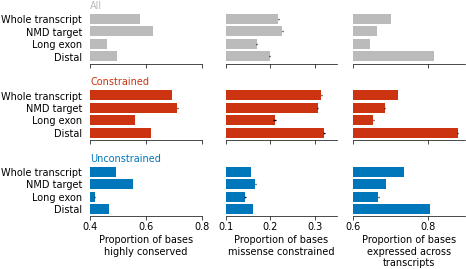

In [14]:
# Instantiate the figure
fig, axs = plt.subplots(
    3,
    3,
    figsize=(12 * cm, 7 * cm),
    layout="constrained",
    gridspec_kw={"hspace": 0.1, "wspace":0.05},
    sharey=True,
    sharex="col"
)
axs = axs.flatten()

# Plots
## First column
plot_metrics_by_region(phylop, axs[0], "phylop", "all", legend="All")
plot_metrics_by_region(phylop, axs[3], "phylop", "constrained", legend="Constrained")
plot_metrics_by_region(
    phylop, axs[6], "phylop", "unconstrained", legend="Unconstrained", xlabel="Proportion of bases\nhighly conserved"
)

## Second column
plot_metrics_by_region(hmc, axs[1], "hmc", "all")
plot_metrics_by_region(hmc, axs[4], "hmc", "constrained")
plot_metrics_by_region(hmc, axs[7], "hmc", "unconstrained", xlabel="Proportion of bases\nmissense constrained")

## Third column
plot_metrics_by_region(pext, axs[2], "pext", "all")
plot_metrics_by_region(pext, axs[5], "pext", "constrained")
plot_metrics_by_region(pext, axs[8], "pext", "unconstrained", xlabel="Proportion of bases\nexpressed across\ntranscripts")

# Set x limits (sharex=True)
axs[0].set_xlim(0.4, 0.8)
axs[1].set_xlim(0.1, 0.35)
axs[2].set_xlim(0.6, 0.9)

# Add panel labels
# Axes = [axs[x] for x in [0, 1, 2]]
# labels = list("ABC")

# for a, l in zip(Axes, labels):
#     panel_label(a,l)
    
# Save to output
plt.savefig("../plots/fig_03.svg", format="svg")
plt.savefig("../plots/fig_03.png", format="png", dpi=1000)
